In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
from sklearn.decomposition import NMF
import os

In [2]:
np.random.seed(42)

# --- Synthetic data generation ---
n_users = 200
n_items = 150
true_rank = 5
noise_std = 0.2

In [3]:
U_true = np.random.normal(scale=1.0, size=(n_users, true_rank))
V_true = np.random.normal(scale=1.0, size=(n_items, true_rank))
M_full = U_true @ V_true.T  # noiseless
M = M_full + np.random.normal(scale=noise_std, size=(n_users, n_items))

In [4]:
mask = np.random.rand(n_users, n_items) > 0.2  # True = train observed, False = held-out test
train_mask = mask.copy()
test_mask = ~train_mask

In [5]:
M_train = M.copy()
M_train[~train_mask] = np.nan

# Helper: RMSE on specific mask entries between true M and reconstructed
def rmse_on_mask(true_mat, recon_mat, mask):
    diff = true_mat[mask] - recon_mat[mask]
    return np.sqrt(np.mean(diff**2))

In [6]:
def als_train(R, mask, rank, reg=0.1, n_iters=25, verbose=False):
    # R: full matrix with np.nan for missing (observed entries are numbers)
    n_users, n_items = R.shape
    # initialize factors
    X = np.random.normal(scale=0.1, size=(n_users, rank))  # user factors
    Y = np.random.normal(scale=0.1, size=(n_items, rank))  # item factors
    # Precompute for speed: lists of item indices observed per user and user indices per item
    user_obs = [np.where(~np.isnan(R[u, :]))[0] for u in range(n_users)]
    item_obs = [np.where(~np.isnan(R[:, i]))[0] for i in range(n_items)]
    for it in range(n_iters):
        # update user factors X (solve least squares for each user)
        for u in range(n_users):
            idx = user_obs[u]
            if len(idx) == 0:
                continue
            Y_i = Y[idx, :]  # items observed by user u
            r_u = R[u, idx]
            A = Y_i.T @ Y_i + reg * np.eye(rank)
            b = Y_i.T @ r_u
            X[u, :] = np.linalg.solve(A, b)
        # update item factors Y
        for i in range(n_items):
            idx = item_obs[i]
            if len(idx) == 0:
                continue
            X_u = X[idx, :]
            r_i = R[idx, i]
            A = X_u.T @ X_u + reg * np.eye(rank)
            b = X_u.T @ r_i
            Y[i, :] = np.linalg.solve(A, b)
        if verbose and (it % 5 == 0 or it == n_iters-1):
            recon = X @ Y.T
            train_rmse = rmse_on_mask(M, recon, train_mask)
            print(f"ALS iter {it+1}/{n_iters}, train RMSE: {train_rmse:.4f}")
    return X, Y


In [7]:
def svd_reconstruct_with_impute(R_train, rank):
    # R_train has np.nan for missing entries
    R_imp = R_train.copy()
    # impute missing with global mean of observed entries
    global_mean = np.nanmean(R_imp)
    R_imp[np.isnan(R_imp)] = global_mean
    # compute truncated SVD via full SVD and truncation (ok for moderate sizes)
    U, s, Vt = svd(R_imp, full_matrices=False)
    U_k = U[:, :rank]
    s_k = s[:rank]
    Vt_k = Vt[:rank, :]
    recon = U_k @ np.diag(s_k) @ Vt_k
    return recon

In [8]:
def nmf_reconstruct(R_train, rank, max_iter=400):
    # NMF requires non-negative matrix. Shift matrix so min > 0.
    R_shift = R_train.copy()
    obs = ~np.isnan(R_shift)
    min_obs = np.nanmin(R_shift)
    if min_obs <= 0:
        shift = -min_obs + 1e-3
    else:
        shift = 0.0
    # fill missing with 0 before NMF (common heuristic) but operate on shifted values
    R_filled = R_shift.copy()
    R_filled[np.isnan(R_filled)] = 0.0
    R_filled += shift
    model = NMF(n_components=rank, init='nndsvda', max_iter=max_iter, random_state=42)
    W = model.fit_transform(R_filled)
    H = model.components_
    recon = W @ H
    # shift back for comparison with original M
    recon -= shift
    return recon

In [9]:
ranks = list(range(1, 21))
svd_rmses = []
nmf_rmses = []
als_rmses = []

for r in ranks:
    # SVD (mean imputation)
    recon_svd = svd_reconstruct_with_impute(M_train, r)
    svd_rmse = rmse_on_mask(M, recon_svd, test_mask)
    svd_rmses.append(svd_rmse)
    # NMF (shift + fill zeros)
    try:
        recon_nmf = nmf_reconstruct(M_train, r)
        nmf_rmse = rmse_on_mask(M, recon_nmf, test_mask)
    except Exception as e:
        recon_nmf = np.full_like(M, np.nan)
        nmf_rmse = np.nan
    nmf_rmses.append(nmf_rmse)
    # ALS (on observed entries)
    X, Y = als_train(M_train, train_mask, rank=r, reg=0.1, n_iters=30, verbose=False)
    recon_als = X @ Y.T
    als_rmse = rmse_on_mask(M, recon_als, test_mask)
    als_rmses.append(als_rmse)
    print(f"rank {r:2d} | SVD RMSE: {svd_rmse:.4f} | NMF RMSE: {nmf_rmse:.4f} | ALS RMSE: {als_rmse:.4f}")


c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


rank  1 | SVD RMSE: 1.9198 | NMF RMSE: 2.2423 | ALS RMSE: 1.8982
rank  2 | SVD RMSE: 1.6589 | NMF RMSE: 1.9274 | ALS RMSE: 1.6115
rank  3 | SVD RMSE: 1.3571 | NMF RMSE: 1.6721 | ALS RMSE: 1.2774
rank  4 | SVD RMSE: 1.0419 | NMF RMSE: 1.3996 | ALS RMSE: 0.8822
rank  5 | SVD RMSE: 0.6763 | NMF RMSE: 1.0978 | ALS RMSE: 0.2071
rank  6 | SVD RMSE: 0.7698 | NMF RMSE: 0.7866 | ALS RMSE: 0.2102
rank  7 | SVD RMSE: 0.8568 | NMF RMSE: 0.7930 | ALS RMSE: 0.2136
rank  8 | SVD RMSE: 0.9250 | NMF RMSE: 0.8169 | ALS RMSE: 0.2168
rank  9 | SVD RMSE: 0.9849 | NMF RMSE: 0.8740 | ALS RMSE: 0.2195
rank 10 | SVD RMSE: 1.0413 | NMF RMSE: 0.9021 | ALS RMSE: 0.2234
rank 11 | SVD RMSE: 1.0926 | NMF RMSE: 0.8821 | ALS RMSE: 0.2257
rank 12 | SVD RMSE: 1.1406 | NMF RMSE: 0.9040 | ALS RMSE: 0.2296
rank 13 | SVD RMSE: 1.1828 | NMF RMSE: 0.9316 | ALS RMSE: 0.2323
rank 14 | SVD RMSE: 1.2210 | NMF RMSE: 0.9183 | ALS RMSE: 0.2358
rank 15 | SVD RMSE: 1.2576 | NMF RMSE: 0.9396 | ALS RMSE: 0.2391
rank 16 | SVD RMSE: 1.292

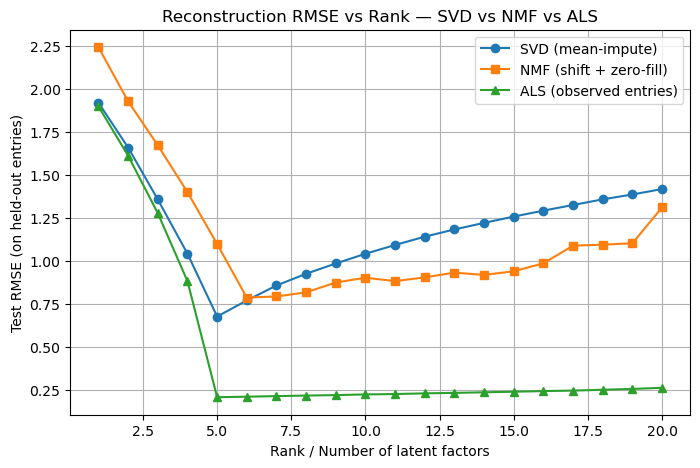

In [10]:
plt.figure(figsize=(8,5))
plt.plot(ranks, svd_rmses, marker='o', label='SVD (mean-impute)')
plt.plot(ranks, nmf_rmses, marker='s', label='NMF (shift + zero-fill)')
plt.plot(ranks, als_rmses, marker='^', label='ALS (observed entries)')
plt.xlabel('Rank / Number of latent factors')
plt.ylabel('Test RMSE (on held-out entries)')
plt.title('Reconstruction RMSE vs Rank — SVD vs NMF vs ALS')
plt.legend()
plt.grid(True)

In [ ]:
# Print best ranks per method
best_svd_rank = ranks[int(np.nanargmin(svd_rmses))] if not all(np.isnan(svd_rmses)) else None
best_nmf_rank = ranks[int(np.nanargmin(nmf_rmses))] if not all(np.isnan(nmf_rmses)) else None
best_als_rank = ranks[int(np.nanargmin(als_rmses))] if not all(np.isnan(als_rmses)) else None
print("\nBest ranks by lowest test RMSE:")
print(f" SVD best rank: {best_svd_rank}, RMSE={np.nanmin(svd_rmses):.4f}")
print(f" NMF best rank: {best_nmf_rank}, RMSE={np.nanmin(nmf_rmses):.4f}")
print(f" ALS best rank: {best_als_rank}, RMSE={np.nanmin(als_rmses):.4f}")


Best ranks by lowest test RMSE:
 SVD best rank: 5, RMSE=0.6763
 NMF best rank: 6, RMSE=0.7866
 ALS best rank: 5, RMSE=0.2071
